**Introduction:**

Using simple random search. In our case, the cost function is just the reach error -- calculated by the reach error between the previous lamdba values and the current one. 

Error is defined as reach error: $ error = ||t-y||^2 $ and the perturbation term $ p_{2k+1} $ can be thought of a normal distribution.

$$ FR+ = FR - \frac{\nu}{N\delta} \sum_{n = 1}^N ( error(FR + \delta p) - error(FR) ) \cdot  p, p \sim \mathcal{N}(0,\sigma^2) $$

Note: p is a perturbation taken from a distribution with mean = 0

References:

[1] G. Cauwenberghs, “A Fast Stochastic Error-Descent Algorithm for Supervised Learning and Optimization,” in Advances in Neural Information Processing Systems 5, S. J. Hanson, J. D. Cowan, and C. L. Giles, Eds. Morgan-Kaufmann, 1993, pp. 244–251.

[2] R. Héliot, K. Ganguly, J. Jimenez, and J. M. Carmena, “Learning in Closed-Loop Brain–Machine Interfaces: Modeling and Experimental Validation,” IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 40, no. 5, pp. 1387–1397, Oct. 2010, doi: 10.1109/TSMCB.2009.2036931.


In [1]:
import numpy as np
from numpy import linalg
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set()


### Brain Modeling

In [2]:
# Brain Model 
###################
# Function that calculates firing rate from b, W, t
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (2.a, 2.b) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# targ_vect = 2 x 1
## OUTPUT
# newFR = N x 1
def brainFiringRate(lambda_vect, targ_vect):
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1)
    newFR = np.zeros( (np.size(lambda_vect, 0), 1) )
    newFR[:, 0] = np.matmul(lambda_vect, targ_vect_mult)
    return newFR

###################
# Function that alters the lambda paramters (b, W) for the brain
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (6) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# delta_perturb = N x 1
# targ_vect = 2 x 1
## MIDDLE
# targ_vect_mult = 3 x 1 [1 t_x t_y]'
# targ_matx = N x 3
# delta_matx = N x 3
# next_term = delta_matx*delta_matx (element-wise mult) = N x 3
## OUTPUT
# lambda_vect_new = N x 3

def calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect):
    # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
    num_neurons = np.size(lambda_vect.copy(), 0)
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1) # 3 x 1  
    targ_matx = (np.matlib.repmat(targ_vect_mult, num_neurons, 1)) # N x 3

    # next gradient term: \gamma*delta_perturb
    delta_matx = np.matlib.repmat(delta_perturb, 1, 3) # N x 3
    next_term = (delta_matx*targ_matx) # 3 x N

    lambda_vect_new = lambda_vect.copy() - (gamma*next_term)
    return lambda_vect_new


### Decoder Model

In [3]:
####################
# Decoder Model 
# Affine Function that calculates target postion from firing rate
# Y = D(f) = a + Kf --> Weiner Filter
# This is Equation (1) in Heliot et al, 2010

## INPUT
# N = number of neurons, d = dimension of target
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
# targ_vect = target position (T_x, Y_y)
## OUTPUT
# Cursor position = Y_x, Y_y
def decoder_findY(decoder_params, brain_params):
    # check firing rate 
    # Start with affine decoder
    (a_vect_in, k_matx_in) = decoder_params
    (fr_curr, targ) = brain_params
    a_vect = a_vect_in.copy()
    k_matx = k_matx_in.copy()
    cursor_pos = a_vect + np.dot(k_matx, np.squeeze(np.asarray(fr_curr)))
    return (cursor_pos)

# Function uses stochastic gradient descent to adjust decoder parameters
## INPUT
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
## OUTPUT
# next decoder parameters = a_next, k_next
def calcNextDecoder(decoder_params, brain_vars):
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    cost_func_args = ( (a_vect, k_matx), brain_vars)
    # a vector
    if (ADAPT_DEC == True):
        a_grad = findErrorGrad(a_vect.copy(), A_VAR, a_dist,error_costFunc, cost_func_args)
        k_grad = findErrorGrad(k_matx.copy(), K_VAR, k_dist, error_costFunc, cost_func_args)
        a_next = a_vect.copy().reshape(np.shape(a_grad)) - a_rate*a_grad
        k_next = k_matx.copy() - k_rate*k_grad
    else:
        a_next = a_vect
        k_next = k_matx

    return (a_next, k_next)

    
    

### Reach Error

In [4]:
####################
# Reach error
# This is Equation (3) in Heliot et al, 2010

## INPUT
# y_x, y_y = predicted cursor position
# t_x, t_y = target position
## OUTPUT
# norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def calcReachError(y_vect, t_vect):
    norm_vect = np.array(y_vect) - np.array(t_vect)
    return (np.linalg.norm(norm_vect, 2)**2)

## INPUT
# cost_func_params = decoder params (a vect, k matx) and current firing rate
## OUTPUT
# reach error = scalar; norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def error_costFunc(cost_func_params):
    (decoder_params, brain_vars) = cost_func_params
    (fr_curr, targ_vect) = brain_vars
    y_vect = decoder_findY(decoder_params, brain_vars)
    t_vect = targ_vect
    return calcReachError(y_vect, t_vect)  


### Stochastic Error Descent: Update Calculation

In [5]:
import random
import time


## Stochastic Error Descent
# This is Equation (4) and Equation (5) in Heliot, 2010
# Derivation is found in Cauwenberghs, 1993 

# This function is one iteration of the error descent calcuation
## INPUT
# input_vect = vector to stochastically perturb
# input_var = FR_VAR, A_VAR OR K_VAR 
# param_dist = distribution from which perturbations to the input are selected
# cost_func = cost function (always reach error)
# cost_func_args = arguments to the cost function (depends on error cost function)
## OUTPUT
# errorGrad = gradient for updating parameter (input vect)
def findErrorGrad(input_vect, input_var, param_dist, cost_func, cost_func_args):
    # Un-nest everything
    (sigma, delta, num_dist) = param_dist
    (decoder_params, (curr_fr, targ_vect) ) = cost_func_args
    (a_vect, k_matx) = decoder_params
    
    # Get size of input vector
    num_neurons = np.size(k_matx, 1)
    num_input_row = np.size(input_vect, 0) 
    num_input_column = 1
    if (input_vect.ndim > 1): 
        num_input_column = np.size(input_vect, 1)
    
    # What to perturb and input firing rate for error cost function
    input_vect = input_vect.copy().reshape(num_input_row, num_input_column)
    input_fr = curr_fr.copy().reshape(num_neurons, 1)
       
    error_sum = np.zeros((num_input_row, 1)) 
    error_grad = np.zeros((num_input_row, 1))
    perturb_rand = np.zeros((num_input_row, num_input_column, num_dist))
    
    
    for iC in range(num_input_column):
        for iN in range(num_input_row):
            random.seed(time.time())
            perturb_rand[iN, iC, :] = np.random.uniform(0, sigma, num_dist) 
            # perturb_rand = N_input x N_dist
            # for each iteration, np.random.normal returns a N_dist x 1 array
    
    for iD in range(num_dist):
        # perturb_vect = stochastic pertrbation (amount of stochastic descent perturbation)
        perturb_vect = np.squeeze(perturb_rand[:, :, [iD]])
        perturb_vect = perturb_vect.copy().reshape(num_input_row, num_input_column)
        
        # find the delta error caused by the perturbation (direction to descend gradient in) 
        input_perturb = np.add(input_vect, delta*perturb_vect) 
        
        # Case 1: firing rate
        # error = reachError(a + K*fr')
        if (input_var == FR_VAR):        
            # Calculate error 
            perturb_cost_args = (decoder_params, (input_perturb, targ_vect) ) 
            
        # case 2: a
        # error = reachError(a' + K*fr)
        elif (input_var == A_VAR):
            decoder_params_perturb = (input_perturb, k_matx)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))

        # case 3: k
        # error = reachError(a + K'*fr)
        elif (input_var == K_VAR):
            decoder_params_perturb = (a_vect, input_perturb)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))   
        
        # default: do nothing
        else:
            perturb_cost_args = cost_func_args
        
        error_perturb = cost_func(perturb_cost_args)   
        error_input = cost_func(cost_func_args)
        error_sum = np.add(error_sum, (error_perturb - error_input)*perturb_vect)

    error_grad = np.array(error_sum/(num_dist*delta))
    return error_grad



### Stochastic Gradient Descent: Update Step and Recalculate Error

In [6]:
# This function goes through and updates brain paramters over the num_iter times
def brain_adapt_sgd(brain_params, decoder_params, targ_vect, num_iter):
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
    (fr_init, targ_vect)= brain_vars
    (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_init, a_rate, a_dist, k_init, k_rate, k_dist) = decoder_params
    decoder_init = (a_init, k_init)
    grad_args_init = (decoder_init, brain_vars)
    

    num_neurons = np.size(fr_init, 0)
    runs_num = 1

    # for sigma in sigma_list:
    for iR in range(runs_num):
        # Set the u vectors
        fr_vect = np.zeros( (num_neurons, 1, num_iter) )
        fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
#         fr_vect[:, 0] = fr_init
        fr_final = np.zeros((num_neurons, 1, runs_num))
        re_final = np.zeros(runs_num)
        lambda_final = np.zeros((num_neurons, np.size(lambda_init, 1), runs_num))

        print("starting fr vect = " + str( fr_vect[:, :, 0] ))
        # lambda init = N x 3
        # lambda_vect = N x 3 X ITER
        lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
        lambda_vect[:,:,0] = lambda_init 

        # set the cost vector
        err_vect = np.zeros(num_iter)
        err_vect[0] = error_costFunc(grad_args_init)
        print('initial error = ' + str(err_vect[0]))

        # calculate the initial delta e
        grad_new = np.zeros(num_iter)
        grad_new = findErrorGrad(fr_init, FR_VAR, fr_dist, error_costFunc, grad_args_init)

        for iT in range(num_iter-1):
            ## calculate the new u 
            # (1) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
            lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
            lambda_vect[:,:, iT + 1] = lambda_next
            
            # (2) fr+ = B(lambda+)
            fr_next = brainFiringRate(lambda_next, targ_vect)
            fr_vect[:, :, iT+1] = fr_next

            # Update parameters for calculating error and calculate the new cost
            # (3) Calculate the new reach error 
            brain_vars_next = fr_next, targ_vect
            grad_args_next = (decoder_init, brain_vars_next)
            err_next = np.array(error_costFunc(grad_args_next))
            err_vect[iT+1] = err_next

            # (4) calculate the next error descent term to update FR again
            grad_new = findErrorGrad(fr_next, FR_VAR, fr_dist, error_costFunc, grad_args_next)
        
        fr_final[:, :, iR] = fr_next
        re_final[iR] = err_next
        lambda_final[:, :, iR] = lambda_next        

    return (re_final, fr_final, lambda_final)

In [7]:
# This function goes through and updates brain paramters over the num_iter times
def calcNextBrain(brain_params, decoder_params, targ_vect, num_iter):
    # Unpack arguments that are being passed in
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
#     (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    decoder_vals = (a_vect, k_matx)
#     grad_args_init = (decoder_vals, fr_init)
    
    num_neurons = np.size(fr_init, 0)
    fr_vect = np.zeros( (num_neurons, 1, num_iter) )
    fr_final = np.zeros( np.size(fr_init) )
    fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
    
    # lambda init = N x 3
    # lambda_vect = N x 3 X ITER
    lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
    lambda_vect[:, :, 0] = lambda_init 
    lambda_final = np.zeros(np.size(lambda_init))
    
    for iT in range(num_iter-1):
#         print("in calc brain: " + str(iT))
        # (1) calculate the perturbation
        brain_vars = (fr_vect[:, :, iT], targ_vect)
        grad_args = (decoder_vals, brain_vars)
        grad_new = findErrorGrad(fr_vect[:, :, iT], FR_VAR, fr_dist, error_costFunc, grad_args)
       
        # (2) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
        lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
        lambda_vect[:,:, iT + 1] = lambda_next
       
        # (2) fr+ = B(lambda+)
        fr_next = brainFiringRate(lambda_next, targ_vect)
        fr_vect[:, :, iT + 1] = fr_next
       
    lambda_final = lambda_next
    fr_final = fr_next

    return  (fr_final, lambda_final)

### Generate New Trial

In [12]:
def findNextTarget(curr_cursor, prev_targ):
    ## random
    x_pos = int(np.random.random_sample()*10)
    y_pos = int(np.random.random_sample()*10)
    
    ## Testing
#     x_pos = prev_targ[0] + 1
#     y_pos = prev_targ[1] + 1

    return np.array( [x_pos, y_pos] )

### Set initial conditions

In [14]:
########
## Set some initial conditions here

# Helper info:
# fr_init = N x 1
# lambda init = N x 3
# baseline = 1 x N
# target_vector = 2 x 1
# K_matx = 2 x N
# A = 2 x 1

NUM_NEURONS = 2
NUM_DIM = 2
NUM_LAMBDA = NUM_DIM + 1

print("INITIAL CONDITIONS")
print("NUM NEURONS = " + str(NUM_NEURONS))
# target position
TARGET_VECTOR = np.array( [1 ,1])
TARGET_ERROR = np.array([0, 0])
TARGET_VECTOR_ERR = TARGET_VECTOR + TARGET_ERROR
print("initial target = " + str(TARGET_VECTOR_ERR))

# firing rate 
fr_init = np.zeros( (NUM_NEURONS, 1) ) 

# BASELINE (b)
BASELINE = (0*np.random.random_sample(NUM_NEURONS)).astype(int) # random float [0, 1)
print("baseline shape = " + str(np.shape(BASELINE)))
print("b =" + str(BASELINE))

# decoder initial paramters
K_MATX = np.random.random_sample( (NUM_DIM, NUM_NEURONS) ) # random float [0, 1)
A_VECT = (- np.matmul(K_MATX, BASELINE)) * 0
print("K MATX = " + str(K_MATX))
print("A = " + str(A_VECT))

# lambda
lambda_init = np.zeros((NUM_NEURONS, NUM_LAMBDA))
W_init = np.linalg.pinv(K_MATX) + np.random.random_sample( (NUM_NEURONS, NUM_DIM) )
print("W init shape = " + str(np.shape(W_init)))
lambda_init[:, 0  ] = np.array([BASELINE])        # lambda[0] = baseline
lambda_init[:, 1:3] = W_init
print("lambda init = ")
print(lambda_init)

# lambda_init[:, 1] = np.random.random_sample(np.shape(lambda_init[:, 0]))    # lambda[2] = w_y
# lambda_init[:, 2] = np.random.random_sample(np.shape(lambda_init[:, 0]))*10 
# # lambda_init[:, 1] = np.array([0.4, 0.6, 1, 2])  # lambda[1] = w_x
# # lambda_init[:, 2] = np.array([3, 5, 4, 2])      # lambda[2] = w_

# SGD initial parameters
# Mapping for variables
FR_VAR = 1
A_VAR = 2
K_VAR = 3

# Brain
FR_SIGMA = 1
FR_DELTA = 1
FR_DIST_SIZE = 10

# Decoder
# A_RATE = 1e-4
A_SIGMA = 1
A_DELTA = 1
A_DIST_SIZE = 100
# --
# K_RATE = 5e-4
K_SIGMA = 1
K_DELTA = 1
K_DIST_SIZE = 100

# display parameters
fig_x = 10
fig_y = 5



INITIAL CONDITIONS
NUM NEURONS = 2
initial target = [1 1]
baseline shape = (2,)
b =[0 0]
K MATX = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]
A = [-0. -0.]
W init shape = (2, 2)
lambda init = 
[[0.         1.28553713 0.24065869]
 [0.         0.05713666 1.73240207]]


### Adaptive Decoder

target at trial 0= [1 1]
K MATX INIT= [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]
A VECT INIT = [-0. -0.]
lambda
[[0.         1.28553713 0.24065869]
 [0.         0.05713666 1.73240207]]
a
[-0. -0.]
K
[[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #0 | lambda learn rate = 0.005
Target = [1. 1.]
fr start of trial
[[1.52619582]
 [1.78953873]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[1.52619582],
       [1.78953873]]), array([1., 1.])))
re start = 0.279122771899957
cursor start = [1.36916012 1.37794652]
fr end of trial = [[1.51741025]
 [1.78263797]]
lambda end of trial = [[0.         1.28260861 0.23773017]
 [0.         0.05483641 1.73010181]]
cursor end = [1.36143143 1.37212619]
re end = 0.2691105798631739
re diff = -0.010012192036783107
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #1 | lambda learn rate = 0.005
Target = [3. 3.]
fr start of trial
[[4.56101632]
 [5.3

 [1.16347088]]
lambda end of trial = [[ 0.          1.02360909  0.00312637]
 [ 0.         -0.20682301  1.51206692]]
cursor end = [7.83781203 2.33347039]
re end = 1.461883379553592
re diff = -0.24077809141317164
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #24 | lambda learn rate = 0.005
Target = [5. 7.]
fr start of trial
[[5.13993005]
 [9.55035341]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[5.13993005],
       [9.55035341]]), array([5., 7.])))
re start = 0.08246886869853093
cursor start = [4.76947829 6.82874402]
fr end of trial = [[5.13383129]
 [9.55275242]]
lambda end of trial = [[ 0.          1.02320251  0.00255715]
 [ 0.         -0.20666307  1.51229083]]
cursor end = [4.76443641 6.82916822]
re end = 0.08467370225395865
re diff = 0.002204833555427721
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #25 | lambda learn rate = 0.005
Target = [4. 7.]
fr st

 [0.17471984 0.62099234]]

Trial #46 | lambda learn rate = 0.005
Target = [8. 8.]
fr start of trial
[[ 8.17522856]
 [10.19841973]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 8.17522856],
       [10.19841973]]), array([8., 8.])))
re start = 0.4644415959611543
cursor start = [7.36159061 7.76151511]
fr end of trial = [[ 8.29785715]
 [10.29977072]]
lambda end of trial = [[ 0.          1.04977582 -0.01266251]
 [ 0.         -0.2084329   1.49580603]]
cursor end = [7.46969359 7.84587895]
re end = 0.30497818580584757
re diff = -0.15946341015530674
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #47 | lambda learn rate = 0.005
Target = [4. 3.]
fr start of trial
[[4.16111578]
 [3.6536865 ]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[4.16111578],
       [3.6536865 ]]), array([4., 3.])))
re start = 0.10378403272034102
curs

       [2.69081818]]), array([8., 3.])))
re start = 0.8849202770390528
cursor start = [7.06551001 3.10792927]
fr end of trial = [[8.32508345]
 [2.74064856]]
lambda end of trial = [[ 0.          1.05645621 -0.04264265]
 [ 0.         -0.21144153  1.47716913]]
cursor end = [7.15283434 3.156479  ]
re end = 0.7421753321599696
re diff = -0.1427449448790833
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #59 | lambda learn rate = 0.005
Target = [5. 0.]
fr start of trial
[[ 5.28228107]
 [-1.05720764]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 5.28228107],
       [-1.05720764]]), array([5., 0.])))
re start = 0.4158027724302886
cursor start = [4.41277514 0.26640147]
fr end of trial = [[ 5.27810294]
 [-1.07698584]]
lambda end of trial = [[ 0.          1.05565273 -0.04264265]
 [ 0.         -0.21524503  1.47716913]]
cursor end = [4.40835797 0.25338935]
re end = 0.41424645803015236
re diff = -0.0

       [11.42367913]]), array([2., 8.])))
re start = 0.3434903992923791
cursor start = [2.12797045 7.42806122]
fr end of trial = [[ 1.9032715 ]
 [11.43080926]]
lambda end of trial = [[ 0.          1.07471692 -0.03075469]
 [ 0.         -0.21334708  1.48217501]]
cursor end = [2.1210188  7.43098423]
re end = 0.33842449976427585
re diff = -0.005065899528103268
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #79 | lambda learn rate = 0.005
Target = [8. 2.]
fr start of trial
[[8.536226  ]
 [1.25757342]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[8.536226  ],
       [1.25757342]]), array([8., 2.])))
re start = 0.6152400724547734
cursor start = [7.26444379 2.2723915 ]
fr end of trial = [[8.52961844]
 [1.23722137]]
lambda end of trial = [[ 0.          1.07395083 -0.03094621]
 [ 0.         -0.21570673  1.4815851 ]]
cursor end = [7.25794942 2.25859856]
re end = 0.6175122719032832
re diff = 0.002

Target = [6. 0.]
fr start of trial
[[ 6.49718618]
 [-1.28199145]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 6.49718618],
       [-1.28199145]]), array([6., 0.])))
re start = 0.441561517737096
cursor start = [5.42852301 0.33908047]
fr end of trial = [[ 6.45641617]
 [-1.33693861]]
lambda end of trial = [[ 0.          1.07625301 -0.05131099]
 [ 0.         -0.22257559  1.48511113]]
cursor end = [5.39162685 0.29783537]
re end = 0.4588237947587556
re diff = 0.01726227702165961
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #95 | lambda learn rate = 0.005
Target = [6. 1.]
fr start of trial
[[6.40620708]
 [0.14965758]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[6.40620708],
       [0.14965758]]), array([6., 1.])))
re start = 0.3860191180229255
cursor start = [5.41606633 1.21222769]
fr end of trial = [[6.39196315]
 [

 [8.62719428]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[7.49370023],
       [8.62719428]]), array([7., 7.])))
re start = 0.19203059426180086
cursor start = [6.71547445 6.66671963]
fr end of trial = [[7.50765367]
 [8.64279849]]
lambda end of trial = [[ 0.          1.07786277 -0.00536096]
 [ 0.         -0.20546048  1.44012346]]
cursor end = [6.72795815 6.67884767]
re end = 0.1771455926892363
re diff = -0.01488500157256456
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #22 | lambda learn rate = 0.005
Target = [9. 1.]
fr start of trial
[[ 9.69540401]
 [-0.40902087]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 9.69540401],
       [-0.40902087]]), array([9., 1.])))
re start = 0.8852842184821518
cursor start = [8.1683142  1.43998062]
fr end of trial = [[ 9.67565113]
 [-0.46809094]]
lambda end of trial = [[ 0.      

 [5.51613341]]
lambda end of trial = [[ 0.          1.07038661 -0.03401198]
 [ 0.         -0.21520088  1.43289554]]
cursor end = [1.03647875 3.58862761]
re end = 0.17055794144664901
re diff = 0.00298696292356726
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #39 | lambda learn rate = 0.005
Target = [1. 0.]
fr start of trial
[[ 1.07038661]
 [-0.21520088]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 1.07038661],
       [-0.21520088]]), array([1., 0.])))
re start = 0.014053887042137116
cursor start = [0.89414871 0.05337968]
fr end of trial = [[ 1.06608112]
 [-0.21933176]]
lambda end of trial = [[ 0.          1.06823387 -0.03401198]
 [ 0.         -0.21726632  1.43289554]]
cursor end = [0.89032747 0.05006218]
re end = 0.01453428655037436
re diff = 0.00048039950823724337
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #40 | lambda learn rate = 0.005
Target = [9.

 [3.63680563]]
lambda end of trial = [[ 0.          1.08094434 -0.03104889]
 [ 0.         -0.22410545  1.43650722]]
cursor end = [2.82242144 2.80860685]
re end = 0.06816548349098808
re diff = 0.007068098931291435
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #58 | lambda learn rate = 0.005
Target = [7. 2.]
fr start of trial
[[7.50451256]
 [1.30427627]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[7.50451256],
       [1.30427627]]), array([7., 2.])))
re start = 0.38024471373894375
cursor start = [6.39537486 2.1211328 ]
fr end of trial = [[7.49725273]
 [1.28134041]]
lambda end of trial = [[ 0.          1.08000325 -0.03131778]
 [ 0.         -0.22707862  1.43565775]]
cursor end = [6.38821356 2.10562137]
re end = 0.38543852046157606
re diff = 0.00519380672263231
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #59 | lambda learn rate = 0.005
Target = [1. 4.]
fr s

re start = 0.23230599033804997
cursor start = [1.10342091 4.52924518]
fr end of trial = [[0.92127859]
 [7.0296827 ]]
lambda end of trial = [[ 0.          1.09302174 -0.03426628]
 [ 0.         -0.22098872  1.45014571]]
cursor end = [1.09396445 4.52634472]
re end = 0.23317863916247608
re diff = 0.0008726488244261144
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #76 | lambda learn rate = 0.005
Target = [3. 6.]
fr start of trial
[[3.07346753]
 [8.03790812]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[3.07346753],
       [8.03790812]]), array([3., 6.])))
re start = 0.22422103268925592
cursor start = [2.95658009 5.52847509]
fr end of trial = [[3.05444034]
 [8.03548372]]
lambda end of trial = [[ 0.          1.09178084 -0.03674809]
 [ 0.         -0.22114683  1.44982949]]
cursor end = [2.94040471 5.52364513]
re end = 0.23046556221493922
re diff = 0.006244529525683301
a = [-0. -0.]
k = [[0.844

 [-0.92836544]]
lambda end of trial = [[ 0.          1.08718921 -0.04692887]
 [ 0.         -0.23183558  1.45544466]]
cursor end = [3.62958388 0.18315622]
re end = 0.17075429892409472
re diff = 0.004471565781770381
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #97 | lambda learn rate = 0.005
Target = [8. 4.]
fr start of trial
[[8.50979816]
 [3.96709398]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[8.50979816],
       [3.96709398]]), array([8., 4.])))
re start = 0.40702941500162787
cursor start = [7.3639451  3.95036553]
fr end of trial = [[8.54650459]
 [3.98238327]]
lambda end of trial = [[ 0.          1.09081453 -0.04511621]
 [ 0.         -0.23032553  1.45619968]]
cursor end = [7.39562704 3.96627341]
re end = 0.3664041618068592
re diff = -0.040625253194768673
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #98 | lambda learn rate = 0.005
Target = [0. 2.]
fr

cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[7.59673418],
       [7.50863011]]), array([7., 6.])))
re start = 0.061509737525826946
cursor start = [6.75218603 5.99010193]
fr end of trial = [[7.54256995]
 [7.46905293]]
lambda end of trial = [[ 0.          1.04463305  0.0384614 ]
 [ 0.         -0.23851787  1.5231897 ]]
cursor end = [6.70467095 5.95606124]
re end = 0.089149865426893
re diff = 0.027640127901066056
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #15 | lambda learn rate = 0.005
Target = [1. 4.]
fr start of trial
[[1.19847865]
 [5.85424093]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[1.19847865],
       [5.85424093]]), array([1., 4.])))
re start = 0.09980132694942188
cursor start = [1.27518301 3.84483675]
fr end of trial = [[1.18269817]
 [5.83627831]]
lambda end of trial = [[ 0.          1.04375636  0.03

 [12.46340548]]
lambda end of trial = [[ 0.          1.04414361 -0.00496282]
 [ 0.         -0.23920253  1.49117187]]
cursor end = [4.04848631 8.461441  ]
re end = 0.2923967198366983
re diff = 0.02376119030569751
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #28 | lambda learn rate = 0.005
Target = [9. 6.]
fr start of trial
[[9.36751556]
 [6.79420849]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[9.36751556],
       [6.79420849]]), array([9., 6.])))
re start = 0.636540584019252
cursor start = [8.2152968  5.85584222]
fr end of trial = [[9.51826148]
 [6.90255549]]
lambda end of trial = [[ 0.          1.05564118  0.00270223]
 [ 0.         -0.23093877  1.49668104]]
cursor end = [8.3474563  5.94946317]
re end = 0.42836724822402505
re diff = -0.2081733357952269
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #29 | lambda learn rate = 0.005
Target = [2. 4.]
fr star

 [6.49049212]]
lambda end of trial = [[ 0.          1.06726561 -0.02266994]
 [ 0.         -0.22827459  1.48079863]]
cursor end = [3.80051691 4.75656296]
re end = 0.09905509778554301
re diff = 0.011958271005544835
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #45 | lambda learn rate = 0.005
Target = [9. 2.]
fr start of trial
[[9.56005064]
 [0.90712598]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[9.56005064],
       [0.90712598]]), array([9., 2.])))
re start = 0.8410139842271709
cursor start = [8.1131955 2.2336488]
fr end of trial = [[9.60549683]
 [0.91005633]]
lambda end of trial = [[ 0.          1.07202161 -0.02161305]
 [ 0.         -0.22796792  1.48086678]]
cursor end = [8.15170156 2.24340888]
re end = 0.7788581253379948
re diff = -0.062155858889176074
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #46 | lambda learn rate = 0.005
Target = [8. 7.]
fr sta

fr start of trial
[[7.42145197]
 [4.18410266]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[7.42145197],
       [4.18410266]]), array([7., 4.])))
re start = 0.30836932433607417
cursor start = [6.45471279 3.89497058]
fr end of trial = [[7.44053344]
 [4.19546658]]
lambda end of trial = [[ 0.          1.08144855 -0.03247388]
 [ 0.         -0.23996844  1.46876837]]
cursor end = [6.47133589 3.9053614 ]
re end = 0.28844220177130975
re diff = -0.01992712256476442
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #63 | lambda learn rate = 0.005
Target = [2. 3.]
fr start of trial
[[2.06547545]
 [3.92636823]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[2.06547545],
       [3.92636823]]), array([2., 3.])))
re start = 0.04665679148916186
cursor start = [1.92059175 2.79912412]
fr end of trial = [[2.05317238]
 [3.9118882 ]]
lambd

 [0.17471984 0.62099234]]

Trial #85 | lambda learn rate = 0.005
Target = [2. 2.]
fr start of trial
[[2.08708589]
 [2.46164661]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[2.08708589],
       [2.46164661]]), array([2., 2.])))
re start = 0.027513062268135012
cursor start = [1.8729873  1.89331899]
fr end of trial = [[2.0775149 ]
 [2.45337231]]
lambda end of trial = [[ 0.          1.08629822 -0.04700904]
 [ 0.         -0.24124307  1.46838891]]
cursor end = [1.86453365 1.88650847]
re end = 0.031231457745173653
re diff = 0.0037183954770386406
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #86 | lambda learn rate = 0.005
Target = [2. 0.]
fr start of trial
[[ 2.17259643]
 [-0.48248614]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 2.17259643],
       [-0.48248614]]), array([2., 0.])))
re start = 0.04142982892375927
cu

       [8.75702048]]), array([9., 7.])))
re start = 0.6855141100161766
cursor start = [8.17342371 7.04780947]
fr end of trial = [[9.31413364]
 [8.82428069]]
lambda end of trial = [[ 0.          1.04490615 -0.01297008]
 [ 0.         -0.18091179  1.49313905]]
cursor end = [8.26149119 7.10717461]
re end = 0.5568816629719118
re diff = -0.1286324470442648
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #16 | lambda learn rate = 0.005
Target = [5. 8.]
fr start of trial
[[ 5.12077013]
 [11.04055344]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 5.12077013],
       [11.04055344]]), array([5., 8.])))
re start = 0.0943940603844924
cursor start = [4.82029741 7.7507992 ]
fr end of trial = [[ 5.0615371 ]
 [10.98584988]]
lambda end of trial = [[ 0.          1.04161543 -0.01823524]
 [ 0.         -0.18395087  1.48827651]]
cursor end = [4.76782222 7.70647952]
re end = 0.14006079504482105
re diff = 0.04

fr end of trial = [[ 3.96294612]
 [11.0967237 ]]
lambda end of trial = [[ 0.          1.05549602 -0.03234939]
 [ 0.         -0.18544215  1.47979523]]
cursor end = [3.84516761 7.58338568]
re end = 0.19754056301641396
re diff = 0.0021202062181368553
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #41 | lambda learn rate = 0.005
Target = [8. 4.]
fr start of trial
[[8.31457061]
 [4.43564371]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[8.31457061],
       [4.43564371]]), array([8., 4.])))
re start = 0.6510874476779135
cursor start = [7.22016231 4.20722119]
fr end of trial = [[8.35587221]
 [4.45336311]]
lambda end of trial = [[ 0.          1.05957519 -0.03030981]
 [ 0.         -0.18369209  1.48067026]]
cursor end = [7.25583361 4.22544101]
re end = 0.6046072628654605
re diff = -0.046480184812452974
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #42 | lambda learn

cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[9.42129204],
       [1.18602585]]), array([9., 2.])))
re start = 1.1293196529419804
cursor start = [8.00856811 2.3825996 ]
fr end of trial = [[9.48929126]
 [1.17713196]]
lambda end of trial = [[ 0.          1.06250849 -0.0370379 ]
 [ 0.         -0.19677054  1.47408513]]
cursor end = [8.06558612 2.38895738]
re end = 1.024417139809798
re diff = -0.10490251313218235
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #55 | lambda learn rate = 0.005
Target = [9. 3.]
fr start of trial
[[9.45146268]
 [2.65132051]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[9.45146268],
       [2.65132051]]), array([9., 3.])))
re start = 0.8988303292882602
cursor start = [8.09992175 3.29780777]
fr end of trial = [[9.49525042]
 [2.65528042]]
lambda end of trial = [[ 0.          1.06683914 -0.03559

 [7.1730434 ]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[8.29704508],
       [7.1730434 ]]), array([8., 6.])))
re start = 0.46020465061474947
cursor start = [7.32843406 5.90406336]
fr end of trial = [[8.360993  ]
 [7.23075339]]
lambda end of trial = [[ 0.          1.07344804 -0.03787075]
 [ 0.         -0.2040443   1.4770894 ]]
cursor end = [7.38502562 5.95107379]
re end = 0.3805872618003911
re diff = -0.07961738881435837
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #79 | lambda learn rate = 0.005
Target = [9. 1.]
fr start of trial
[[ 9.62316163]
 [-0.35930928]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 9.62316163],
       [-0.35930928]]), array([9., 1.])))
re start = 1.0028777874808883
cursor start = [8.10954842 1.45822896]
fr end of trial = [[ 9.71844494]
 [-0.34505123]]
lambda end of trial = [[ 0.      

a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #93 | lambda learn rate = 0.005
Target = [7. 1.]
fr start of trial
[[ 7.52165424]
 [-0.05263384]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 7.52165424],
       [-0.05263384]]), array([7., 1.])))
re start = 0.5032445627583617
cursor start = [6.34884411 1.28149702]
fr end of trial = [[ 7.50968616]
 [-0.0867448 ]]
lambda end of trial = [[ 0.          1.07954797 -0.04691497]
 [ 0.         -0.22264167  1.47241573]]
cursor end = [6.33720479 1.25822331]
re end = 0.5059767646433234
re diff = 0.0027322018849617047
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #94 | lambda learn rate = 0.005
Target = [1. 8.]
fr start of trial
[[ 0.7042282 ]
 [11.55668414]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 0.7042282 ],
       [11.55668414]]), array(

Target = [8. 7.]
fr start of trial
[[8.08017651]
 [9.27313982]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[8.08017651],
       [9.27313982]]), array([8., 7.])))
re start = 0.6070177677105525
cursor start = [7.23973014 7.1703159 ]
fr end of trial = [[8.12327314]
 [9.26612022]]
lambda end of trial = [[ 0.          1.05903005 -0.04990647]
 [ 0.         -0.14195121  1.48597021]]
cursor end = [7.27580491 7.17348661]
re end = 0.554556127170249
re diff = -0.052461640540303445
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #11 | lambda learn rate = 0.005
Target = [3. 6.]
fr start of trial
[[2.87765133]
 [8.48996762]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[2.87765133],
       [8.48996762]]), array([3., 6.])))
re start = 0.08614064212202129
cursor start = [2.81155886 5.7749876 ]
fr end of trial = [[2.87173741]
 [8.4

 [0.17471984 0.62099234]]

Trial #27 | lambda learn rate = 0.005
Target = [3. 5.]
fr start of trial
[[2.90908685]
 [6.90143764]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[2.90908685],
       [6.90143764]]), array([3., 5.])))
re start = 0.09686598931355624
cursor start = [2.76668434 4.79401506]
fr end of trial = [[2.90207378]
 [6.89845491]]
lambda end of trial = [[ 0.          1.05208284 -0.05079487]
 [ 0.         -0.16956298  1.48144581]]
cursor end = [2.76062848 4.79093749]
re end = 0.10100585910287706
re diff = 0.004139869789320821
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #28 | lambda learn rate = 0.005
Target = [0. 2.]
fr start of trial
[[-0.10158975]
 [ 2.96289162]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[-0.10158975],
       [ 2.96289162]]), array([0., 2.])))
re start = 0.03386808084149664
curso

re start = 0.13170216348634023
cursor start = [3.64461449 3.92649282]
fr end of trial = [[4.03798225]
 [5.18068944]]
lambda end of trial = [[ 0.          1.0633686  -0.05385674]
 [ 0.         -0.17980056  1.4750148 ]]
cursor end = [3.64254973 3.92268405]
re end = 0.13374845214213615
re diff = 0.0020462886557959248
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #45 | lambda learn rate = 0.005
Target = [2. 7.]
fr start of trial
[[1.74974002]
 [9.96550248]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[1.74974002],
       [9.96550248]]), array([2., 7.])))
re start = 0.26136877408604653
cursor start = [1.92549995 6.49421495]
fr end of trial = [[1.73367976]
 [9.96501775]]
lambda end of trial = [[ 0.          1.06277377 -0.05593862]
 [ 0.         -0.17981851  1.47495196]]
cursor end = [1.91191703 6.49110789]
re end = 0.26672978864154834
re diff = 0.0053610145555018085
a = [-0. -0.]
k = [[0.84

       [2.76790576]]), array([1., 2.])))
re start = 0.017233813721630298
cursor start = [0.93420166 1.8864025 ]
fr end of trial = [[0.95338843]
 [2.76445169]]
lambda end of trial = [[ 0.          1.06240585 -0.05404208]
 [ 0.         -0.18891364  1.47697051]]
cursor end = [0.92931812 1.88327919]
re end = 0.01861967638985883
re diff = 0.0013858626682285331
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #61 | lambda learn rate = 0.005
Target = [3. 9.]
fr start of trial
[[ 2.70083886]
 [12.72599363]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 2.70083886],
       [12.72599363]]), array([3., 9.])))
re start = 0.4127771588837545
cursor start = [2.8527067  8.37463463]
fr end of trial = [[ 2.72834552]
 [12.77776372]]
lambda end of trial = [[ 0.          1.06331266 -0.05132164]
 [ 0.         -0.18720693  1.48209062]]
cursor end = [2.87826057 8.41158942]
re end = 0.3610474977665224
re diff = 

 [0.17471984 0.62099234]]

Trial #90 | lambda learn rate = 0.005
Target = [4. 0.]
fr start of trial
[[ 4.29672453]
 [-0.82100622]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 4.29672453],
       [-0.82100622]]), array([4., 0.])))
re start = 0.2251425361196061
cursor start = [3.59120028 0.24088446]
fr end of trial = [[ 4.27750889]
 [-0.84325457]]
lambda end of trial = [[ 0.          1.0696598  -0.0507997 ]
 [ 0.         -0.21048646  1.48203156]]
cursor end = [3.57397452 0.22371105]
re end = 0.2315443446121857
re diff = 0.006401808492579597
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #91 | lambda learn rate = 0.005
Target = [2. 9.]
fr start of trial
[[ 1.68212233]
 [12.91731113]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 1.68212233],
       [12.91731113]]), array([2., 9.])))
re start = 0.46860810559241584
c

 [13.96806156]]
lambda end of trial = [[ 0.          1.12877727  0.1047631 ]
 [ 0.         -0.08615226  1.60949281]]
cursor end = [ 7.14234949 10.02200056]
re end = 2.3494475106024817
re diff = -0.25899121360460553
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #18 | lambda learn rate = 0.001
Target = [7. 5.]
fr start of trial
[[8.42525636]
 [7.44439825]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[8.42525636],
       [7.44439825]]), array([7., 5.])))
re start = 1.4004733784841252
cursor start = [7.44889418 6.0949737 ]
fr end of trial = [[8.33570957]
 [7.35457067]]
lambda end of trial = [[ 0.          1.12041957  0.09879331]
 [ 0.         -0.09453617  1.60350431]]
cursor end = [7.36924322 6.02354586]
re end = 1.1839866773540342
re diff = -0.21648670113009105
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #19 | lambda learn rate = 0.001
Target = [0. 3.]
fr 

fr start of trial
[[3.45987404]
 [5.83532282]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[3.45987404],
       [5.83532282]]), array([3., 4.])))
re start = 0.08586930378631188
cursor start = [3.18383239 4.22819938]
fr end of trial = [[3.45229512]
 [5.82481493]]
lambda end of trial = [[ 0.          1.07982658  0.05327672]
 [ 0.         -0.13528761  1.55777048]]
cursor end = [3.1769604  4.22034988]
re end = 0.07986905359137803
re diff = -0.006000250194933859
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #34 | lambda learn rate = 0.001
Target = [9. 2.]
fr start of trial
[[9.82499263]
 [1.89795249]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[9.82499263],
       [1.89795249]]), array([9., 2.])))
re start = 1.1840422492720677
cursor start = [8.38145624 2.89523509]
fr end of trial = [[9.80571513]
 [1.87050974]]
lambd

re start = 0.32635896888348265
cursor start = [1.52553946 6.77601955]
fr end of trial = [[ 1.2251256 ]
 [10.54902177]]
lambda end of trial = [[ 0.          1.05712349  0.02405412]
 [ 0.         -0.16209643  1.53019469]]
cursor end = [1.50875502 6.76491541]
re end = 0.31409643856593716
re diff = -0.012262530317545484
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #50 | lambda learn rate = 0.001
Target = [1. 6.]
fr start of trial
[[1.20144821]
 [9.0190717 ]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[1.20144821],
       [9.0190717 ]]), array([1., 6.])))
re start = 0.21221881878693544
cursor start = [1.41997739 5.81069123]
fr end of trial = [[1.17781115]
 [8.99811642]]
lambda end of trial = [[ 0.          1.05650146  0.02032195]
 [ 0.         -0.16264788  1.52688596]]
cursor end = [1.39907637 5.7935483 ]
re end = 0.20188425050299702
re diff = -0.010334568283938417
a = [-0. -0.]
k = [[0.

fr end of trial = [[5.21616593]
 [6.65709943]]
lambda end of trial = [[ 0.          1.04499264 -0.00172155]
 [ 0.         -0.17612519  1.50758513]]
cursor end = [4.70377396 5.0453754 ]
re end = 0.0898087929126212
re diff = 0.00424004240134955
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #67 | lambda learn rate = 0.001
Target = [7. 1.]
fr start of trial
[[7.31322696]
 [0.27470881]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[7.31322696],
       [0.27470881]]), array([7., 1.])))
re start = 0.8610720293913496
cursor start = [6.1875671  1.44835791]
fr end of trial = [[7.31259156]
 [0.26857225]]
lambda end of trial = [[ 0.          1.04490543 -0.00173401]
 [ 0.         -0.17696746  1.50746481]]
cursor end = [6.18675469 1.44443614]
re end = 0.8588914187784651
re diff = -0.002180610612884548
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #68 | lambda learn rate

       [1.11928936]]), array([2., 1.])))
re start = 0.040447300024288625
cursor start = [1.80763935 1.05869141]
fr end of trial = [[2.07997479]
 [1.11784398]]
lambda end of trial = [[ 0.          1.04394575 -0.00771788]
 [ 0.         -0.19052603  1.49913693]]
cursor end = [1.80656704 1.05758541]
re end = 0.040732387639550956
re diff = 0.0002850876152623305
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #97 | lambda learn rate = 0.001
Target = [6. 5.]
fr start of trial
[[6.22508511]
 [6.3525285 ]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[6.22508511],
       [6.3525285 ]]), array([6., 5.])))
re start = 0.21081936038761512
cursor start = [5.5420022  5.03251738]
fr end of trial = [[6.2225016]
 [6.3450987]]
lambda end of trial = [[ 0.          1.04369573 -0.00792623]
 [ 0.         -0.19124504  1.49853776]]
cursor end = [5.53948668 5.02745214]
re end = 0.21282613836211664
re diff = 0.002

 [10.65779049]]
lambda end of trial = [[ 0.          1.15219251  0.10395433]
 [ 0.         -0.07643711  1.59913553]]
cursor end = [7.90316372 8.15456884]
re end = 2.148733901297289
re diff = -0.3458530388063523
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #16 | lambda learn rate = 0.001
Target = [8. 3.]
fr start of trial
[[9.52940309]
 [4.18590971]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[9.52940309],
       [4.18590971]]), array([8., 3.])))
re start = 1.6537880765885928
cursor start = [8.23472711 4.26439363]
fr end of trial = [[9.47098532]
 [4.13067489]]
lambda end of trial = [[ 0.          1.14587708  0.10158604]
 [ 0.         -0.08240844  1.59689628]]
cursor end = [8.18291643 4.21988648]
re end = 1.521581456751691
re diff = -0.13220661983690185
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #17 | lambda learn rate = 0.001
Target = [3. 9.]
fr start

 [10.46003907]]
lambda end of trial = [[ 0.          1.08813834  0.04169599]
 [ 0.         -0.14581311  1.53602117]]
cursor end = [2.55371665 6.9267074 ]
re end = 0.31197393717410776
re diff = -0.037605881886936976
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #36 | lambda learn rate = 0.001
Target = [8. 3.]
fr start of trial
[[8.83019466]
 [3.44155867]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[8.83019466],
       [3.44155867]]), array([8., 3.])))
re start = 0.6138208161768999
cursor start = [7.61085731 3.67999175]
fr end of trial = [[8.80380853]
 [3.41998985]]
lambda end of trial = [[ 0.          1.08528578  0.04062628]
 [ 0.         -0.14814487  1.53514676]]
cursor end = [7.58760742 3.66198751]
re end = 0.6082950982634288
re diff = -0.005525717913471118
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #37 | lambda learn rate = 0.001
Target = [5. 0.]
fr

       [2.33271074]]), array([4., 2.])))
re start = 0.11530332997941961
cursor start = [3.72370815 2.19739844]
fr end of trial = [[4.28212257]
 [2.32843263]]
lambda end of trial = [[ 0.          1.06497989  0.01118753]
 [ 0.         -0.17185061  1.5080194 ]]
cursor end = [3.72046543 2.19411059]
re end = 0.11581849320399489
re diff = 0.0005151632245752741
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #59 | lambda learn rate = 0.001
Target = [5. 4.]
fr start of trial
[[5.36964954]
 [5.17282453]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[5.36964954],
       [5.17282453]]), array([5., 4.])))
re start = 0.0770964002480176
cursor start = [4.76664282 4.15046869]
fr end of trial = [[5.36378584]
 [5.16326488]]
lambda end of trial = [[ 0.          1.06428183  0.01062908]
 [ 0.         -0.17298866  1.50710895]]
cursor end = [4.76126179 4.14350772]
re end = 0.07759039959524376
re diff = 0.0004

k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #71 | lambda learn rate = 0.001
Target = [9. 4.]
fr start of trial
[[9.509133  ]
 [4.34287234]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[9.509133  ],
       [4.34287234]]), array([9., 4.])))
re start = 0.7295361126431548
cursor start = [8.22466809 4.35832463]
fr end of trial = [[9.50787453]
 [4.33796582]]
lambda end of trial = [[ 0.          1.05710405 -0.00151227]
 [ 0.         -0.18271654  1.49561618]]
cursor end = [8.22338486 4.35505784]
re end = 0.7291971473969825
re diff = -0.00033896524617227364
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #72 | lambda learn rate = 0.001
Target = [1. 3.]
fr start of trial
[[1.05256724]
 [4.304132  ]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[1.05256724],
       [4.304132  ]]), array([1., 3.])))
re start =

 [0.17419284]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[7.34745624],
       [0.17419284]]), array([7., 1.])))
re start = 0.7746217462930792
cursor start = [6.21195089 1.3919188 ]
fr end of trial = [[7.34410667]
 [0.16428004]]
lambda end of trial = [[ 0.          1.05135397 -0.01530547]
 [ 0.         -0.1885725   1.48448188]]
cursor end = [6.20867689 1.38517779]
re end = 0.7745542038205345
re diff = -6.754247254470158e-05
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #86 | lambda learn rate = 0.001
Target = [0. 6.]
fr start of trial
[[-0.09183281]
 [ 8.9068913 ]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[-0.09183281],
       [ 8.9068913 ]]), array([0., 6.])))
re start = 0.3394253143030057
cursor start = [0.3229002  5.51506621]
fr end of trial = [[-0.1032954 ]
 [ 8.90312218]]
lambda end of trial = [[ 0.     

 [15.65879655]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 4.6967498 ],
       [15.65879655]]), array([2., 9.])))
re start = 9.514123216864306
cursor start = [ 4.66988938 10.54460801]
fr end of trial = [[ 4.52146512]
 [15.48257347]]
lambda end of trial = [[0.         1.27954951 0.21826714]
 [0.         0.05085263 1.70921303]]
cursor end = [ 4.51395796 10.40454911]
re end = 8.292742832346502
re diff = -1.2213803845178042
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #3 | lambda learn rate = 0.001
Target = [1. 3.]
fr start of trial
[[1.93435094]
 [5.17849173]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[1.93435094],
       [5.17849173]]), array([1., 3.])))
re start = 1.056907295773327
cursor start = [1.86616545 3.55377316]
fr end of trial = [[1.92479809]
 [5.16962352]]
lambda end of trial = [[0.         1.27868

 [0.17471984 0.62099234]]

Trial #24 | lambda learn rate = 0.001
Target = [4. 2.]
fr start of trial
[[4.76690407]
 [2.9521743 ]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[4.76690407],
       [2.9521743 ]]), array([4., 2.])))
re start = 0.4686737654742575
cursor start = [4.15785279 2.66615033]
fr end of trial = [[4.74932887]
 [2.93735854]]
lambda end of trial = [[ 0.          1.15839707  0.05828875]
 [ 0.         -0.0543645   1.57776102]]
cursor end = [4.14234638 2.65387912]
re end = 0.4478203917183995
re diff = -0.020853373755857996
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #25 | lambda learn rate = 0.001
Target = [8. 6.]
fr start of trial
[[9.61690909]
 [9.03165014]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[9.61690909],
       [9.03165014]]), array([8., 6.])))
re start = 1.9383109393039568
cursor star

 [1.52602071]]
lambda end of trial = [[ 0.          1.11156703  0.00633441]
 [ 0.         -0.10115329  1.5263749 ]]
cursor end = [0.07359473 0.94867901]
re end = 0.008050028749556733
re diff = -5.164445239892734e-05
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #38 | lambda learn rate = 0.001
Target = [8. 5.]
fr start of trial
[[8.92420832]
 [6.82264818]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[8.92420832],
       [6.82264818]]), array([8., 5.])))
re start = 0.6585778732614288
cursor start = [7.84225116 5.79604848]
fr end of trial = [[8.86849471]
 [6.7673899 ]]
lambda end of trial = [[ 0.          1.10661471  0.00323921]
 [ 0.         -0.10606514  1.52330499]]
cursor end = [7.79272279 5.75199923]
re end = 0.6084666896407313
re diff = -0.05011118362069755
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #39 | lambda learn rate = 0.001
Target = [9. 0.]
fr

fr end of trial = [[ 2.03456824]
 [11.78479499]]
lambda end of trial = [[ 0.          1.0817661  -0.01607582]
 [ 0.         -0.13632335  1.50721675]]
cursor end = [2.24779924 7.67374679]
re end = 0.16784561724719155
re diff = -0.0005404253846812701
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #57 | lambda learn rate = 0.001
Target = [6. 6.]
fr start of trial
[[6.3941417 ]
 [8.22536041]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[6.3941417 ],
       [8.22536041]]), array([6., 6.])))
re start = 0.10403924907702196
cursor start = [5.76895214 6.22506918]
fr end of trial = [[6.36769032]
 [8.19195384]]
lambda end of trial = [[ 0.          1.07959201 -0.0182499 ]
 [ 0.         -0.1390691   1.50447101]]
cursor end = [5.74511494 6.19970238]
re end = 0.1048474311969741
re diff = 0.0008081821199521361
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #58 | lambda lea


Trial #81 | lambda learn rate = 0.001
Target = [1. 7.]
fr start of trial
[[ 0.78906685]
 [10.24898577]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 0.78906685],
       [10.24898577]]), array([1., 7.])))
re start = 0.26374332884594864
cursor start = [1.12706208 6.50240724]
fr end of trial = [[ 0.77931399]
 [10.24458135]]
lambda end of trial = [[ 0.          1.0658168  -0.04090165]
 [ 0.         -0.15286866  1.48536234]]
cursor end = [1.11862885 6.49796811]
re end = 0.2661088203325819
re diff = 0.002365491486633231
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #82 | lambda learn rate = 0.001
Target = [7. 8.]
fr start of trial
[[ 7.13350435]
 [10.81281809]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 7.13350435],
       [10.81281809]]), array([7., 8.])))
re start = 0.2420181572576791
cursor start = [6.50959158 

 [12.66085762]]
lambda end of trial = [[ 0.          1.17470724  0.12355004]
 [ 0.         -0.04103452  1.62890825]]
cursor end = [10.32989451  9.88195926]
re end = 5.310390087692197
re diff = -1.0019145886621708
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #7 | lambda learn rate = 0.001
Target = [8. 3.]
fr start of trial
[[9.76830801]
 [4.55844856]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[9.76830801],
       [4.55844856]]), array([8., 3.])))
re start = 2.56923587195277
cursor start = [8.45320495 4.53747883]
fr end of trial = [[9.65502235]
 [4.4629362 ]]
lambda end of trial = [[ 0.          1.16246014  0.11895737]
 [ 0.         -0.05136018  1.62503613]]
cursor end = [8.35325354 4.45837314]
re end = 2.2516402707029455
re diff = -0.31759560124982444
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #8 | lambda learn rate = 0.001
Target = [2. 5.]
fr start 

k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #19 | lambda learn rate = 0.001
Target = [4. 8.]
fr start of trial
[[ 4.77244385]
 [12.04285876]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 4.77244385],
       [12.04285876]]), array([4., 8.])))
re start = 0.4238822306545582
cursor start = [4.57123656 8.31236361]
fr end of trial = [[ 4.69325569]
 [11.97527405]]
lambda end of trial = [[ 0.          1.10119551  0.03618141]
 [ 0.         -0.10686446  1.55044579]]
cursor end = [4.50133234 8.25655828]
re end = 0.31715626392286217
re diff = -0.10672596673169604
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #20 | lambda learn rate = 0.001
Target = [7. 8.]
fr start of trial
[[ 7.99781985]
 [11.65551504]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 7.99781985],
       [11.65551504]]), array([7., 8.])))
re

Target = [1. 9.]
fr start of trial
[[ 1.03258081]
 [13.42059797]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 1.03258081],
       [13.42059797]]), array([1., 9.])))
re start = 0.46159544903925526
cursor start = [1.47527466 8.51450083]
fr end of trial = [[ 0.99606304]
 [13.3965064 ]]
lambda end of trial = [[ 0.          1.05954634 -0.00700481]
 [ 0.         -0.15715611  1.50599475]]
cursor end = [1.44335629 8.49315977]
re end = 0.4534518171744904
re diff = -0.008143631864764855
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #47 | lambda learn rate = 0.001
Target = [5. 5.]
fr start of trial
[[5.26270762]
 [6.74419322]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[5.26270762],
       [6.74419322]]), array([5., 5.])))
re start = 0.07559058016406695
cursor start = [4.74698893 5.10759173]
fr end of trial = [[5.2548800

k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #65 | lambda learn rate = 0.001
Target = [0. 4.]
fr start of trial
[[-0.08101432]
 [ 5.97378723]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[-0.08101432],
       [ 5.97378723]]), array([0., 4.])))
re start = 0.13277390686907797
cursor start = [0.20016646 3.69552127]
fr end of trial = [[-0.08805722]
 [ 5.96867623]]
lambda end of trial = [[ 0.          1.05101514 -0.02191073]
 [ 0.         -0.16808722  1.49224422]]
cursor end = [0.19398972 3.69111685]
re end = 0.13304081437400297
re diff = 0.00026690750492500137
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #66 | lambda learn rate = 0.001
Target = [0. 3.]
fr start of trial
[[-0.0657322 ]
 [ 4.47673266]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[-0.0657322 ],
       [ 4.47673266]]), array([0., 3.])))

fr end of trial = [[8.20171673]
 [9.03526681]]
lambda end of trial = [[ 0.          1.04919135 -0.02742064]
 [ 0.         -0.17155643  1.48680876]]
cursor end = [7.33166302 7.04383407]
re end = 0.44859573923056345
re diff = -0.016803292425678906
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #80 | lambda learn rate = 0.001
Target = [7. 1.]
fr start of trial
[[7.31691879]
 [0.28591377]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[7.31691879],
       [0.28591377]]), array([7., 1.])))
re start = 0.8620770713954593
cursor start = [6.19118821 1.45596114]
fr end of trial = [[7.32009483]
 [0.28378695]]
lambda end of trial = [[ 0.          1.04962727 -0.02735837]
 [ 0.         -0.17184834  1.48676706]]
cursor end = [6.1937744  1.45519532]
re end = 0.857202492648491
re diff = -0.004874578746968283
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #81 | lambda learn ra

re start = 0.14519000386483144
cursor start = [4.68234477 6.78955961]
fr end of trial = [[5.03916373]
 [9.51630919]]
lambda end of trial = [[ 0.          1.0495937  -0.02983036]
 [ 0.         -0.17527022  1.48466473]]
cursor end = [4.68286162 6.78999695]
re end = 0.1446780338809317
re diff = -0.0005119699838997405
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #95 | lambda learn rate = 0.001
Target = [0. 4.]
fr start of trial
[[-0.11932145]
 [ 5.93865892]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[-0.11932145],
       [ 5.93865892]]), array([0., 4.])))
re start = 0.13851584196097727
cursor start = [0.16624097 3.66701384]
fr end of trial = [[-0.12670729]
 [ 5.9339485 ]]
lambda end of trial = [[ 0.          1.0495937  -0.03156821]
 [ 0.         -0.17527022  1.4835564 ]]
cursor end = [0.15979267 3.66279826]
re end = 0.13923871263902146
re diff = 0.0007228706780441907
a = [-0. -0.]
k = 

 [0.01522438]]
lambda end of trial = [[0.         1.23664553 0.18554277]
 [0.         0.01558255 1.68820038]]
cursor end = [1.04456013 0.22545129]
re end = 0.05281388996175878
re diff = -0.0003267239259486729
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #9 | lambda learn rate = 0.001
Target = [3. 4.]
fr start of trial
[[4.45210769]
 [6.79954916]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[4.45210769],
       [6.79954916]]), array([3., 4.])))
re start = 2.1349361915457274
cursor start = [4.0650151  5.00033945]
fr end of trial = [[4.43340485]
 [6.76636992]]
lambda end of trial = [[0.         1.23448751 0.18266541]
 [0.         0.01175417 1.68309588]]
cursor end = [4.04773091 4.97646764]
re end = 2.051229117399313
re diff = -0.08370707414641432
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #10 | lambda learn rate = 0.001
Target = [5. 1.]
fr start of trial

re start = 0.375308857942489
cursor start = [3.81649869 0.58449647]
fr end of trial = [[ 4.53174401]
 [-0.34238751]]
lambda end of trial = [[ 0.          1.13302346  0.10171735]
 [ 0.         -0.08549524  1.60596614]]
cursor end = [3.81116651 0.57916557]
re end = 0.3710908488054432
re diff = -0.004218009137045842
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #25 | lambda learn rate = 0.001
Target = [2. 5.]
fr start of trial
[[2.77463365]
 [7.85884023]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[2.77463365],
       [7.85884023]]), array([2., 5.])))
re start = 0.6179613731764575
cursor start = [2.69619704 5.36506309]
fr end of trial = [[2.74786959]
 [7.83855377]]
lambda end of trial = [[ 0.          1.13123919  0.09725667]
 [ 0.         -0.08684767  1.60258507]]
cursor end = [2.67268568 5.34778915]
re end = 0.5734633079663701
re diff = -0.04449806521008737
a = [-0. -0.]
k = [[0.844390

 [0.17471984 0.62099234]]

Trial #42 | lambda learn rate = 0.001
Target = [4. 2.]
fr start of trial
[[4.41647818]
 [2.56041087]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[4.41647818],
       [2.56041087]]), array([4., 2.])))
re start = 0.1550138218533442
cursor start = [3.84434343 2.36164189]
fr end of trial = [[4.41134259]
 [2.55488588]]
lambda end of trial = [[ 0.          1.07948764  0.04681829]
 [ 0.         -0.1395187   1.55661189]]
cursor end = [3.8397586  2.35731362]
re end = 0.15335032987106614
re diff = -0.0016634919822780536
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #43 | lambda learn rate = 0.001
Target = [2. 2.]
fr start of trial
[[2.25261186]
 [2.83418638]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[2.25261186],
       [2.83418638]]), array([2., 2.])))
re start = 0.02445857398773245
cursor s

cursor start = [7.12859369 2.42029949]
fr end of trial = [[8.36826033]
 [1.54228526]]
lambda end of trial = [[ 0.          1.04385303  0.00865832]
 [ 0.         -0.18630855  1.5163989 ]]
cursor end = [7.13541553 2.41984844]
re end = 0.9237790134919925
re diff = -0.01222160089569746
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #72 | lambda learn rate = 0.001
Target = [4. 2.]
fr start of trial
[[4.19272877]
 [2.2875636 ]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[4.19272877],
       [2.2875636 ]]), array([4., 2.])))
re start = 0.15078905331220818
cursor start = [3.64314477 2.15311236]
fr end of trial = [[4.19027805]
 [2.28506521]]
lambda end of trial = [[ 0.          1.04338623  0.00842492]
 [ 0.         -0.18678443  1.51616096]]
cursor end = [3.64096308 2.15113269]
re end = 0.15174859682563313
re diff = 0.0009595435134249486
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0

 [ 6.01726569]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[-0.02075585],
       [ 6.01726569]]), array([0., 4.])))
re start = 0.13527306055201482
cursor start = [0.25300286 3.73304941]
fr end of trial = [[-0.02875789]
 [ 6.0129773 ]]
lambda end of trial = [[ 0.          1.03819277 -0.0070718 ]
 [ 0.         -0.19545782  1.50330739]]
cursor end = [0.24605321 3.72898824]
re end = 0.13398955513540683
re diff = -0.0012835054166079884
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #95 | lambda learn rate = 0.001
Target = [0. 0.]
fr start of trial
[[0.]
 [0.]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[0.],
       [0.]]), array([0., 0.])))
re start = 0.0
cursor start = [0. 0.]
fr end of trial = [[-0.00037555]
 [-0.00028134]]
lambda end of trial = [[ 0.          1.03819277 -0.0070718 ]
 [ 0.         -0.19545782  1.50

 [0.17471984 0.62099234]]

Trial #13 | lambda learn rate = 0.0001
Target = [6. 9.]
fr start of trial
[[ 9.62167002]
 [15.68494895]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 9.62167002],
       [15.68494895]]), array([6., 9.])))
re start = 13.869581887078409
cursor start = [ 8.8296191  11.42132973]
fr end of trial = [[ 9.58480833]
 [15.65323785]]
lambda end of trial = [[0.         1.26757498 0.21996343]
 [0.         0.03906832 1.71323296]]
cursor end = [ 8.79706776 11.3951969 ]
re end = 13.560556256864448
re diff = -0.3090256302139611
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #14 | lambda learn rate = 0.0001
Target = [7. 3.]
fr start of trial
[[9.53291514]
 [5.41317713]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[9.53291514],
       [5.41317713]]), array([7., 3.])))
re start = 5.780770239924615
cursor s

 [10.2864368 ]]
lambda end of trial = [[0.         1.24215626 0.19838098]
 [0.         0.01690474 1.69470774]]
cursor end = [8.80940397 8.11493344]
re end = 7.746886172408561
re diff = -0.10360088728363248
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #38 | lambda learn rate = 0.0001
Target = [0. 3.]
fr start of trial
[[0.59514294]
 [5.08412321]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[0.59514294],
       [5.08412321]]), array([0., 3.])))
re start = 0.6027375258871598
cursor start = [0.73110876 3.26118482]
fr end of trial = [[0.59425017]
 [5.08333263]]
lambda end of trial = [[0.         1.24215626 0.19811315]
 [0.         0.01690474 1.69447056]]
cursor end = [0.73031937 3.26053789]
re end = 0.6012463774527421
re diff = -0.0014911484344176662
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #39 | lambda learn rate = 0.0001
Target = [1. 1.]
fr start of tr

 [0.17471984 0.62099234]]

Trial #54 | lambda learn rate = 0.0001
Target = [6. 0.]
fr start of trial
[[7.39063064]
 [0.04195791]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[7.39063064],
       [0.04195791]]), array([6., 0.])))
re start = 1.7941864944842714
cursor start = [6.24246181 1.31734535]
fr end of trial = [[7.3866901 ]
 [0.03865752]]
lambda end of trial = [[0.         1.23113277 0.184205  ]
 [0.         0.00645779 1.68169942]]
cursor end = [6.23898607 1.31460733]
re end = 1.7853067865638548
re diff = -0.00887970792041659
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #55 | lambda learn rate = 0.0001
Target = [7. 7.]
fr start of trial
[[ 9.90736439]
 [11.81710045]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 9.90736439],
       [11.81710045]]), array([7., 7.])))
re start = 7.88064415783637
cursor start =

cursor end = [6.60566699 8.46902235]
re end = 4.7361931374351105
re diff = -0.032600196489918076
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #73 | lambda learn rate = 0.0001
Target = [5. 3.]
fr start of trial
[[6.55219073]
 [4.95219909]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[6.55219073],
       [4.95219909]]), array([5., 3.])))
re start = 2.058986326172403
cursor start = [5.75524986 4.2200754 ]
fr end of trial = [[6.54970678]
 [4.9491212 ]]
lambda end of trial = [[ 0.          1.21218292  0.16295438]
 [ 0.         -0.00880402  1.66440974]]
cursor end = [5.75301406 4.21773005]
re end = 2.049896653353846
re diff = -0.009089672818556771
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #74 | lambda learn rate = 0.0001
Target = [7. 4.]
fr start of trial
[[9.13709797]
 [6.59601085]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],


 [0.17471984 0.62099234]]

Trial #91 | lambda learn rate = 0.0001
Target = [9. 5.]
fr start of trial
[[11.55880274]
 [ 8.07554985]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[11.55880274],
       [ 8.07554985]]), array([9., 5.])))
re start = 5.400401455285318
cursor start = [10.12320556  7.03440673]
fr end of trial = [[11.54322951]
 [ 8.0562271 ]]
lambda end of trial = [[ 0.          1.19905214  0.15038116]
 [ 0.         -0.02281914  1.65235599]]
cursor end = [10.10918695  7.01968649]
re end = 5.309429200336337
re diff = -0.09097225494898176
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #92 | lambda learn rate = 0.0001
Target = [7. 7.]
fr start of trial
[[ 9.44603308]
 [11.40675794]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 9.44603308],
       [11.40675794]]), array([7., 7.])))
re start = 5.223507814336879

       [1.84903539]]), array([3., 1.])))
re start = 0.9745217822863762
cursor start = [3.49486072 1.85418654]
fr end of trial = [[4.03950231]
 [1.84778973]]
lambda end of trial = [[0.         1.27155295 0.22493116]
 [0.         0.04276277 1.71961467]]
cursor end = [3.49399017 1.85324446]
re end = 0.9720523893938378
re diff = -0.0024693928925384467
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #18 | lambda learn rate = 0.0001
Target = [8. 3.]
fr start of trial
[[10.84721706]
 [ 5.50094615]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[10.84721706],
       [ 5.50094615]]), array([8., 3.])))
re start = 7.320486052725864
cursor start = [9.40659862 5.31126943]
fr end of trial = [[10.83664472]
 [ 5.49048482]]
lambda end of trial = [[0.         1.27040999 0.22450255]
 [0.         0.04163181 1.71919056]]
cursor end = [9.39720111 5.30292582]
re end = 7.255638283141696
re diff = -0.064847769584

Target = [6. 4.]
fr start of trial
[[8.26672483]
 [6.89188043]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[8.26672483],
       [6.89188043]]), array([6., 4.])))
re start = 4.637340893548241
cursor start = [7.2901912  5.72416576]
fr end of trial = [[8.25512727]
 [6.88263804]]
lambda end of trial = [[0.         1.24263115 0.19988979]
 [0.         0.01550537 1.69744504]]
cursor end = [7.2799828  5.71639998]
re end = 4.584384878265133
re diff = -0.052956015283108115
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #44 | lambda learn rate = 0.0001
Target = [4. 4.]
fr start of trial
[[5.77008379]
 [6.85180167]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[5.77008379],
       [6.85180167]]), array([4., 4.])))
re start = 2.9883225315643878
cursor start = [5.18025029 5.26306444]
fr end of trial = [[5.7670678 ]
 [6.84835187

re start = 3.07021905384508
cursor start = [8.3026162  1.72587441]
fr end of trial = [[9.82279125e+00]
 [3.92363271e-03]]
lambda end of trial = [[0.00000000e+00 1.22786660e+00 1.82524010e-01]
 [0.00000000e+00 5.07778147e-04 1.68091015e+00]]
cursor end = [8.29444421 1.71867306]
re end = 3.040534491904115
re diff = -0.02968456194096536
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #65 | lambda learn rate = 0.0001
Target = [0. 1.]
fr start of trial
[[0.18252401]
 [1.68091015]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[0.18252401],
       [1.68091015]]), array([0., 1.])))
re start = 0.058492888405229995
cursor start = [0.22969313 1.07572288]
fr end of trial = [[0.18246687]
 [1.68083491]]
lambda end of trial = [[0.00000000e+00 1.22786660e+00 1.82495440e-01]
 [0.00000000e+00 5.07778147e-04 1.68087253e+00]]
cursor end = [0.2296415  1.07566618]
re end = 0.05846058742773707
re diff = -3.230

 [0.17471984 0.62099234]]

Trial #86 | lambda learn rate = 0.0001
Target = [4. 1.]
fr start of trial
[[5.00455345]
 [1.59889455]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[5.00455345],
       [1.59889455]]), array([4., 1.])))
re start = 0.8408156722732084
cursor start = [4.29767979 1.86729604]
fr end of trial = [[5.00312543]
 [1.59747692]]
lambda end of trial = [[ 0.          1.21009416  0.16282812]
 [ 0.         -0.01650192  1.66356335]]
cursor end = [4.29641024 1.8661662 ]
re end = 0.8381029156714943
re diff = -0.002712756601714106
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #87 | lambda learn rate = 0.0001
Target = [8. 3.]
fr start of trial
[[10.16923764]
 [ 4.8586747 ]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[10.16923764],
       [ 4.8586747 ]]), array([8., 3.])))
re start = 3.866736297981907
cursor

cursor end = [6.76541081 2.64172376]
re end = 3.2811106157271825
re diff = -0.014555676746036195
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #8 | lambda learn rate = 0.0001
Target = [3. 0.]
fr start of trial
[[3.83518363]
 [0.15215055]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[3.83518363],
       [0.15215055]]), array([3., 0.])))
re start = 0.644701245901884
cursor start = [3.24523163 0.764567  ]
fr end of trial = [[3.83486012]
 [0.1516926 ]]
lambda end of trial = [[0.         1.27829749 0.23380028]
 [0.         0.05057947 1.72598655]]
cursor end = [3.24493788 0.76422609]
re end = 0.6440360838442208
re diff = -0.0006651620576632045
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #9 | lambda learn rate = 0.0001
Target = [1. 2.]
fr start of trial
[[1.74589804]
 [3.50255256]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
      

 [1.82233029]]
lambda end of trial = [[0.         1.25718641 0.20730965]
 [0.         0.03050118 1.7004473 ]]
cursor end = [4.50308774 2.04647203]
re end = 1.3482009750403896
re diff = -0.005941479395361382
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #32 | lambda learn rate = 0.0001
Target = [9. 1.]
fr start of trial
[[11.5219873 ]
 [ 1.97495789]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[11.5219873 ],
       [ 1.97495789]]), array([9., 1.])))
re start = 5.684468389745343
cursor start = [9.81784383 3.23955349]
fr end of trial = [[11.50589433]
 [ 1.95719088]]
lambda end of trial = [[0.         1.25544138 0.20711576]
 [0.         0.02857463 1.70023324]]
cursor end = [9.8034563  3.22570855]
re end = 5.5993205810284525
re diff = -0.08514780871689087
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #33 | lambda learn rate = 0.0001
Target = [7. 9.]
fr start o

cursor start = [6.17396442 5.44060778]
fr end of trial = [[6.94450993]
 [6.802045  ]]
lambda end of trial = [[0.         1.23895469 0.18746305]
 [0.         0.0141434  1.68285498]]
cursor end = [6.16968712 5.43736147]
re end = 3.4341759540713404
re diff = -0.01936728231380913
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #54 | lambda learn rate = 0.0001
Target = [0. 1.]
fr start of trial
[[0.18746305]
 [1.68285498]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[0.18746305],
       [1.68285498]]), array([0., 1.])))
re start = 0.060784928025037335
cursor start = [0.23395104 1.07779356]
fr end of trial = [[0.18738316]
 [1.68278794]]
lambda end of trial = [[0.         1.23895469 0.1874231 ]
 [0.         0.0141434  1.68282146]]
cursor end = [0.23388057 1.07773797]
re end = 0.06074331111496438
re diff = -4.161691007295576e-05
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234

cursor end = [3.21125543 5.79234623]
re end = 2.094952260932699
re diff = -0.01581087088878297
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #70 | lambda learn rate = 0.0001
Target = [7. 5.]
fr start of trial
[[9.51602017]
 [8.41493978]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[9.51602017],
       [8.41493978]]), array([7., 5.])))
re start = 5.563638652056886
cursor start = [8.41355871 6.88825063]
fr end of trial = [[9.49972011]
 [8.40065457]]
lambda end of trial = [[0.         1.23031223 0.17755036]
 [0.         0.00499761 1.67317236]]
cursor end = [8.39915285 6.87653168]
re end = 5.478999829349577
re diff = -0.08463882270730849
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #71 | lambda learn rate = 0.0001
Target = [5. 0.]
fr start of trial
[[6.15156117]
 [0.02498803]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0

lambda end of trial = [[ 0.          1.21528092  0.16179017]
 [ 0.         -0.00930754  1.6579686 ]]
cursor end = [9.68387724 9.05721583]
re end = 7.067579517637557
re diff = -0.17666659657093398
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #92 | lambda learn rate = 0.0001
Target = [0. 0.]
fr start of trial
[[0.]
 [0.]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[0.],
       [0.]]), array([0., 0.])))
re start = 0.0
cursor start = [0. 0.]
fr end of trial = [[-2.62282023e-05]
 [-2.99333923e-05]]
lambda end of trial = [[ 0.          1.21528092  0.16179017]
 [ 0.         -0.00930754  1.6579686 ]]
cursor end = [-2.34926033e-05 -2.31709945e-05]
re end = 1.0887973925089876e-09
re diff = 1.0887973925089876e-09
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #93 | lambda learn rate = 0.0001
Target = [7. 8.]
fr start of trial
[[ 9.80128775]
 [13.198596  ]]
cost fun

cursor end = [8.3201394  5.05040287]
re end = 5.946919973846281
re diff = -0.0590936867455385
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #21 | lambda learn rate = 0.0001
Target = [9. 0.]
fr start of trial
[[11.42827568]
 [ 0.37534824]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[11.42827568],
       [ 0.37534824]]), array([9., 0.])))
re start = 5.4167834044884
cursor start = [9.66679817 2.22983488]
fr end of trial = [[11.4055174 ]
 [ 0.35446732]]
lambda end of trial = [[0.         1.26731055 0.22505717]
 [0.         0.03941355 1.71675497]]
cursor end = [9.64664253 2.21289167]
re end = 5.31503608746524
re diff = -0.1017473170231602
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #22 | lambda learn rate = 0.0001
Target = [0. 0.]
fr start of trial
[[0.]
 [0.]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62

 [0.12843072]]
lambda end of trial = [[0.         1.24628066 0.19964842]
 [0.         0.01837091 1.69387363]]
cursor end = [7.37206722 1.60397599]
re end = 2.7111729835510254
re diff = -0.02646822765290624
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #46 | lambda learn rate = 0.0001
Target = [4. 7.]
fr start of trial
[[ 6.38266155]
 [11.93059908]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 6.38266155],
       [11.93059908]]), array([4., 7.])))
re start = 6.031405102607358
cursor start = [5.9258414  8.52398819]
fr end of trial = [[ 6.36366711]
 [11.91694785]]
lambda end of trial = [[0.         1.24512948 0.19763385]
 [0.         0.01754356 1.69242578]]
cursor end = [5.90918895 8.51219217]
re end = 5.93172759263804
re diff = -0.09967750996931724
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #47 | lambda learn rate = 0.0001
Target = [2. 5.]
fr start of t

 [5.0549797]]
lambda end of trial = [[0.         1.23327711 0.18233292]
 [0.         0.00603266 1.67698394]]
cursor end = [4.85453752 4.09657127]
re end = 1.9327029222900696
re diff = -0.008154683535854135
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #65 | lambda learn rate = 0.0001
Target = [8. 9.]
fr start of trial
[[11.50721315]
 [15.14111674]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[11.50721315],
       [15.14111674]]), array([8., 9.])))
re start = 11.569900570281419
cursor start = [10.39730304 11.41305588]
fr end of trial = [[11.45947325]
 [15.09931842]]
lambda end of trial = [[0.         1.23066122 0.17939005]
 [0.         0.00374234 1.67440733]]
cursor end = [10.35511274 11.37875834]
re end = 11.205047246100674
re diff = -0.36485332418074456
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #66 | lambda learn rate = 0.0001
Target = [1. 4.]
fr sta

re end = 6.724147834317036
re diff = -0.12650460743936875
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #84 | lambda learn rate = 0.0001
Target = [5. 8.]
fr start of trial
[[ 7.40259226]
 [13.2387138 ]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 7.40259226],
       [13.2387138 ]]), array([5., 8.])))
re start = 5.7010130322980785
cursor start = [6.84587205 9.51451953]
fr end of trial = [[ 7.38293846]
 [13.22041548]]
lambda end of trial = [[ 0.          1.21487109  0.16360017]
 [ 0.         -0.01147308  1.65974802]]
cursor end = [6.8284539  9.49972251]
re end = 5.592411266287572
re diff = -0.10860176601050675
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #85 | lambda learn rate = 0.0001
Target = [8. 8.]
fr start of trial
[[11.02777011]
 [13.18619956]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]

Trial #10 | lambda learn rate = 0.0001
Target = [5. 1.]
fr start of trial
[[6.6155085 ]
 [1.96642188]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[6.6155085 ],
       [1.96642188]]), array([5., 1.])))
re start = 2.3510315211369472
cursor start = [5.67447788 2.3769935 ]
fr end of trial = [[6.61172427]
 [1.96219184]]
lambda end of trial = [[0.         1.27627624 0.23048323]
 [0.         0.04791986 1.72274922]]
cursor end = [5.67109234 2.3737055 ]
re end = 2.337431723921668
re diff = -0.013599797215279263
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #11 | lambda learn rate = 0.0001
Target = [4. 2.]
fr start of trial
[[5.56607142]
 [3.63717786]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[5.56607142],
       [3.63717786]]), array([4., 2.])))
re start = 2.261322531268959
cursor start = [4.86345873 3.23116268]
fr en

       [11.96579835]]), array([4., 7.])))
re start = 6.224531105440427
cursor start = [5.95394318 8.55133399]
fr end of trial = [[ 6.39559782]
 [11.95164144]]
lambda end of trial = [[0.         1.24058274 0.20479239]
 [0.         0.01411451 1.69934255]]
cursor end = [5.9377107  8.53931555]
re end = 6.12421513450734
re diff = -0.10031597093308697
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #44 | lambda learn rate = 0.0001
Target = [1. 7.]
fr start of trial
[[ 2.67412945]
 [11.9095124 ]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 2.67412945],
       [11.9095124 ]]), array([1., 7.])))
re start = 3.9611112667288007
cursor start = [2.79344554 7.86293938]
fr end of trial = [[ 2.66330335]
 [11.90265627]]
lambda end of trial = [[0.         1.24037046 0.20330645]
 [0.         0.01398008 1.69840152]]
cursor end = [2.78399585 7.85679025]
re end = 3.9167307166124674
re diff = -0.044380550116

re end = 0.7622922028838823
re diff = -0.0017969626185080356
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #60 | lambda learn rate = 0.0001
Target = [7. 3.]
fr start of trial
[[9.15925379]
 [5.07326307]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[9.15925379],
       [5.07326307]]), array([7., 3.])))
re start = 3.9907441557613277
cursor start = [7.96207102 4.75076084]
fr end of trial = [[9.14626002]
 [5.06281657]]
lambda end of trial = [[0.00000000e+00 1.22569061e+00 1.88881998e-01]
 [0.00000000e+00 6.71144664e-04 1.68609854e+00]]
cursor end = [7.95062955 4.74200337]
re end = 3.9382722880954963
re diff = -0.05247186766583134
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #61 | lambda learn rate = 0.0001
Target = [9. 2.]
fr start of trial
[[11.40897948]
 [ 3.37823738]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471

Target = [4. 9.]
fr start of trial
[[ 6.423275  ]
 [15.01383249]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 6.423275  ],
       [15.01383249]]), array([4., 9.])))
re start = 6.494954463402698
cursor start = [ 6.09875339 10.44574848]
fr end of trial = [[ 6.40236516]
 [14.99520437]]
lambda end of trial = [[ 0.          1.21152671  0.1729413 ]
 [ 0.         -0.01315773  1.67200282]]
cursor end = [ 6.08025984 10.4305272 ]
re end = 6.373889059767883
re diff = -0.1210654036348151
a = [-0. -0.]
k = [[0.84439011 0.04495877]
 [0.17471984 0.62099234]]

Trial #79 | lambda learn rate = 0.0001
Target = [5. 8.]
fr start of trial
[[ 7.44116394]
 [13.3102339 ]]
cost func params = ((array([-0., -0.]), array([[0.84439011, 0.04495877],
       [0.17471984, 0.62099234]])), (array([[ 7.44116394],
       [13.3102339 ]]), array([5., 8.])))
re start = 5.9919626971853255
cursor start = [6.88165705 9.56567221]
fr end of trial = [[ 7.430

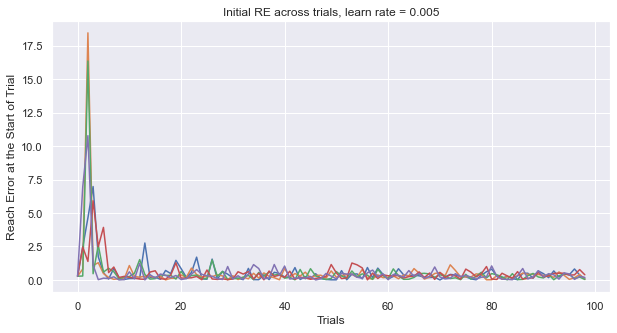

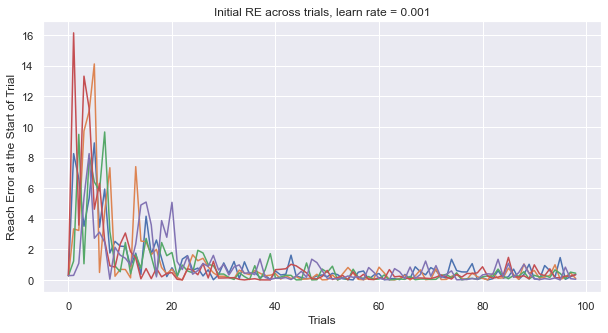

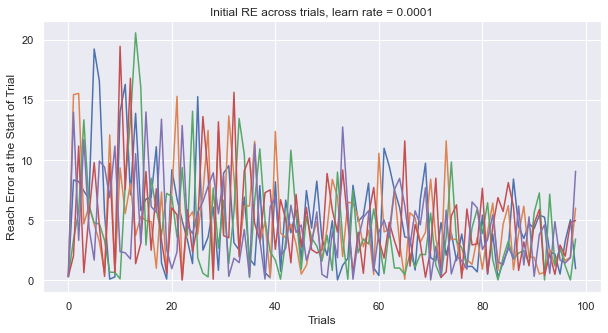

In [15]:
NUM_TRIALS = 100
NUM_RUNS = 2 # Has to be >1
NUM_SESSIONS = 5
rate_list = [5e-3, 1e-3, 1e-4]
A_RATE = 1e-4
K_RATE = 5e-7
ADAPT_TRIALS = NUM_TRIALS
ADAPT_DEC = False

for lambda_rate in rate_list:
    for iS in range(NUM_SESSIONS):
        ## BRAIN SIDE
        FR_DIST = (FR_SIGMA, FR_DELTA, FR_DIST_SIZE)
    #     fr_init[:, 0] = np.array(brainFiringRate(lambda_init, TARGET_VECTOR_ERR))

        ## DECODER SIDE
        A_DIST = (A_SIGMA, A_DELTA, A_DIST_SIZE)
        K_DIST = (K_SIGMA, K_DELTA, K_DIST_SIZE)

        # target position -- new target represents a new trial
        target_trial = np.zeros( (NUM_DIM, NUM_TRIALS) )
        target_trial[:, 0] = TARGET_VECTOR_ERR
        print("target at trial 0= " + str(TARGET_VECTOR_ERR))
        cursor_start = np.zeros( (NUM_DIM, NUM_TRIALS) )
        cursor_end = np.zeros( (NUM_DIM, NUM_TRIALS) )

        print("K MATX INIT= " + str(K_MATX))
        print("A VECT INIT = " + str(A_VECT))

        ## VECTORS FOR TRIALS    
        lambda_trial = np.zeros( (NUM_NEURONS, NUM_LAMBDA, NUM_TRIALS) )
        lambda_trial[:, :, 0] = lambda_init
        print("lambda")
        print(lambda_trial[:, :, 0])

        fr_trial = np.zeros( (NUM_NEURONS, 1, NUM_TRIALS) )

        a_trial = np.zeros( (NUM_DIM, NUM_TRIALS) )
        a_trial[:, 0] = np.array(A_VECT)
        print("a")
        print(a_trial[:, 0])

        k_trial = np.zeros( (NUM_DIM, NUM_NEURONS, NUM_TRIALS) )
        k_trial[:,:,  0] = K_MATX
        print("K")
        print(k_trial[:,:, 0] )
        decoder_params = (a_trial[:, 0], A_RATE, A_DIST, k_trial[:,:,  0], K_RATE, K_DIST)
        decoder_vals = (A_VECT, K_MATX)

        re_startT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )
        re_endT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )

        for iT in range(NUM_TRIALS-1):
            print("")
            print("=========================================")
            print("Trial #" + str(iT) + " | lambda learn rate = " + str(lambda_rate))
            print("Target = " + str(target_trial[:, iT]))

            # calculate firing rate given lambda and decoder parameters with current target position 
            fr_start = np.array(brainFiringRate(lambda_trial[:, :, iT], target_trial[:, iT]))
            fr_trial[:, :, iT] = fr_start
            print("fr start of trial")
            print(fr_start)

            # calculate reach error of firing rate at the beginning of the trial
            # this becomes the error of the new target position being presented and where the cursor is
            brain_vars = (fr_trial[:, :, iT],  target_trial[:, iT])
            cost_func_params = (decoder_vals, brain_vars) 
            
            print("cost func params = "+ str(cost_func_params))
            re_startT[iT, iS] = error_costFunc(cost_func_params)
            print("re start = " + str(re_startT[iT, iS]))

    #         (a_vect_in, k_matx_in) = decoder_params
            cursor_start[:, iT] =  decoder_findY(decoder_vals, brain_vars)
            print("cursor start = " + str(cursor_start[:, iT]) )

            # Run through trial and see the reach at the end        
            # current brain and decoder params
            brain_params = (fr_trial[:, :, iT], FR_DIST, lambda_trial[:, :, iT], lambda_rate)
            decoder_params = (a_trial[:, iT], A_RATE, A_DIST, k_trial[:, :,  iT], K_RATE, K_DIST)

            # adapt brain and decoder (together here)
            a_run, k_run = calcNextDecoder(decoder_params, fr_trial[:, :, iT])
            fr_run, lambda_run = calcNextBrain(brain_params, decoder_params, target_trial[:, iT], NUM_RUNS)
    #         print("fr_run = " + str(fr_run))
#             re_run, fr_run, lambda_run = brain_adapt_sgd(brain_params, decoder_params, target_trial[:, iT], NUM_RUNS)
            # update cost function arguments
            lambda_run[:,0] = 0
            decoder_vals = (a_run, k_run)
            brain_vars = (fr_run, target_trial[:, iT])
            # see how the updated decoder and brain paramters have done with the current
            # target position (so target at trial = iT)
            cost_func_params = (decoder_vals, brain_vars) 
            re_run = np.array(error_costFunc(cost_func_params))

            # So what are the end trial metrics?
            print("fr end of trial = " + str(fr_run))
            print("lambda end of trial = " + str(lambda_run))
            cursor_end[:, iT] =  decoder_findY(decoder_vals, brain_vars)
            print("cursor end = " + str(cursor_end[:, iT]) )

            re_endT[iT, iS] = re_run
            print("re end = " + str(re_endT[iT, iS]))
            print("re diff = " + str(re_endT[iT, iS] - re_startT[iT, iS]))

            # update the parameters
            lambda_trial[:, :, iT + 1] = np.squeeze(lambda_run)
            a_trial[:, iT + 1] = np.squeeze(a_run)
            k_trial[:, :, iT + 1] = np.squeeze(k_run)
            print("a = " + str(a_trial[:, iT + 1]))
            print("k = " + str(k_trial[:, :, iT + 1]))

            # change to new target
            target_trial[:, iT + 1] = findNextTarget( cursor_end[:, iT], target_trial[:, iT] )
    
        # display stuff
#         print("target position:")
#         print(target_trial)
#         print("cursor end: ")
#         print(cursor_end)
#         print("cursor start: ")
#         print(cursor_start)

        
        pidx = rate_list.index(lambda_rate)
        plt.figure(2*pidx + 1, figsize=(fig_x, fig_y))
        plt.plot(np.arange(0, NUM_TRIALS-1, 1), re_startT[0:len(re_startT)-1, iS])
        plt.xlabel('Trials')
        plt.ylabel('Reach Error at the Start of Trial')
        plt.title('Initial RE across trials, learn rate = ' + str(lambda_rate))
        #     plt.show()
        
#         plt.figure(2*pidx + 2, figsize=(fig_x, fig_y))
#         plt.plot(np.arange(0, NUM_TRIALS-1, 1), re_endT[0:len(re_endT)-1, iS])
#         plt.xlabel('Trials' )#, color='white')
#         plt.ylabel('Reach Error at the End of Trial')#, color='white')
#         plt.title('Ending RE across trials | learn rate = ' + str(lambda_rate) + '| Decoder Adapt = ' + str(ADAPT_DEC)) #, color = 'white')
#         #     plt.show()

    